# 11 - 倾向得分

## 成长背后的心理学

积极心理学领域研究人类行为如何带来美好生活。您可以将其视为自助式书籍与统计的学术严谨性之间的交集。积极心理学的著名发现之一是**成长心态**。其核心思想是人们可以拥有固化或是成长两种心态。如果你有固化的心态，那么你相信能力是在出生时或幼儿时期就被赋予的。因此，智力是固定的，终生无法改变。如果你现在没有它，你就无法获得它。这种想法的推论是你不应该在你不擅长的领域浪费时间，因为你永远不会学会如何处理它们。另一方面，如果你有成长的心态，你相信智力是可以发展的。这样做的直接后果是你认为失败不是最终没有坚持下来的结果，而是学习过程的一部分。

我不想争论这些心态中哪一个是正确的（尽管它可能在中间的某个地方）。就我们的目的而言，这并不重要。重要的是，心理学家发现，拥有成长心态的人往往会在生活中做得更好。他们更有可能实现他们的目标。

我们精通因果推理，因此我们已经学会以怀疑的态度看待这些陈述。是成长型思维模式让人们取得更多成就吗？或者仅仅是因为成功而获得更多成就的人容易形成成长心态？谁先来，先有蛋还是先有鸡？在潜在的结果符号中，我们有理由相信这些陈述存在偏见。 \\(Y_0|T=1\\) 可能比 \\(Y_0|T=0\\) 大，这意味着那些拥有成长型思维模式的人即使拥有固定型思维模式也会取得更多成就。

为了解决问题，研究人员设计了 [The National Study of Learning Mindset](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#) 这么一个调研项目。这个研究在美国公立高中进行随机抽样，从而试图发现成长心态的影响。其工作方式是这样的。学生通过在学校参与一个研讨会，得到成长心态这个概念的灌输。然后，研究者跟踪学生在大学期间的表现，以衡量他们在学业上的表现。衡量的结果被编译成标准化的成就分数。为了保护学生的隐私，本研究的真实数据不公开。但是，我们有一个与 [Athey 和 Wager](https://arxiv.org/pdf/1902.07409.pdf) 提供的统计属性相同的模拟数据集，因此我们将改为使用这个数据来进行分析。

In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

除了干预变量和结果变量外，该研究还记录了其他一些特征：

* schoolid：学生所在学校的标识符；
* success_expect：自我报告的对未来成功的期望，代表先验成就，在随机分配之前测量；
* 种族：学生种族/民族的分类变量；
* 性别：学生性别的分类变量；
* frst_in_family：学生第一代身份的分类变量，即是否家庭中第一个上大学的人；
* school_urbanicity：学校级别在城市化程度上的分类变量，即农村、郊区等；
* school_mindset：学生固定心态的学校水平平均值，在随机分配之前报告，标准化；
* school_achievement：学校成绩水平，由前 4 批学生的考试成绩和大学准备来衡量，标准化；
* school_ethnic_minority：学校种族/少数民族组成，即标准化的黑人、拉丁裔或美洲原住民学生人数的百分比；
* school_poverty：学校贫困集中度，即来自家庭收入低于联邦贫困线的学生的百分比，标准化；
* school_size：学校所有四个年级的学生总数，标准化。

In [23]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


尽管这项研究是随机的，但这些数据似乎并非没有混淆。 如果我们查看其他特征，我们会注意到它们在干预和控制之间系统地变化。 造成这种情况的一个可能原因是干预变量是通过学生对研讨会的接受来衡量的。 因此，虽然参与的机会是随机的，但参与本身却不是。 我们正在处理一个不合规的案例。 这方面的一个证据是学生的成功期望如何与研讨会的参与度相关联。 自我报告的成功期望较高的学生更有可能参加成长心态研讨会。

In [24]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

不过，让我们看看 \\(E[Y|T=1] - E[Y|T=0]\\) 的含义有何不同。 这将是一个比较有用的基准。

In [25]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


简单地比较那些有和没有干预的人，我们可以看到，接受干预的人的成就得分平均比未经干预的人高 0.3185 (0.4723 - 0.1538)。但这是大还是小？我知道解释标准化结果可能具有挑战性，但请耐心等待。我认为值得一试，因为这不会是你最后一次遇到标准化分数。

标准化的结果变量意味着它是用标准差来衡量的。因此，经过处理的偏差比未经处理的偏差高 0.3185。这就是这个意思。至于这是小还是大，让我们记住一些关于正态分布的东西。我们知道它 95% 的质量在 2 个标准偏差之间，一条尾巴留下 2.5%，另一条尾巴留下 2.5%。这也意味着，如果某人比平均值高 2 个标准差，那么所有个体中有 97.5%（95% 加上左侧 2.5% 的尾部）低于该人。通过查看正常的 CDF，我们还知道其质量的大约 0.85% 低于 1 个标准偏差，而其质量的 70% 低于 0.5 个标准偏差。由于被干预组的平均标准化分数约为 0.5，这意味着他们在个人成就方面低于 70%。或者，换句话说，他们在取得更多成就的前 30% 中。这是图片中的样子。

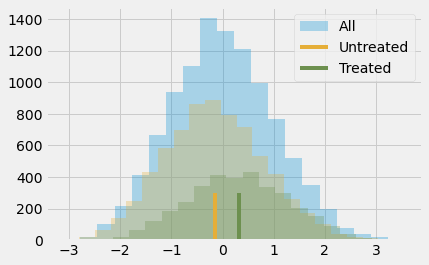

In [26]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

当然，我们仍然认为这个结果是有偏见的。干预和未干预之间的差异可能比这更小，因为我们认为偏差是积极的。我们已经看到，雄心勃勃的人更愿意参加研讨会，所以即使他们没有参加，他们可能也会取得更大的成就。为了控制这种偏差，我们可以使用回归或匹配，但现在是学习新技术的时候了。

## 倾向得分

倾向得分来自于意识到您不需要直接控制混杂因素 X 来实现条件独立 \\((Y_1, Y_0) \perp T | X\\)。相反，控制平衡分数 \\(E[T|X]\\) 就足够了。这个平衡分数通常是干预的条件概率，\\(P(T|X)\\)，也称为倾向评分\\(P(x)\\)。倾向得分使您不必以整个 X 为条件来实现干预潜在结果的独立性。以这个单一变量为条件就足够了，即倾向得分：

$
(Y_1, Y_0) \perp T | P(x)
$

有一个正式的证据来说明为什么会这样，但我们现在可以忘记它并以更直观的方式处理这个问题。倾向得分是接受干预的条件概率，对吗？因此，我们可以将其视为某种将 X 转换为干预 T 的函数。倾向得分在变量 X 和干预变量 T 之间形成了中间地带。如果我们在因果图中显示它，这就是它的样子喜欢。

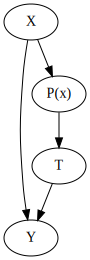

In [27]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

如果我知道 P(x) 是什么，那么仅 X 就不会告诉我更多可以帮助我了解 T 是什么的信息。这意味着控制 P(x) 与直接控制 X 的方式相同。根据我们的心态计划来考虑它。干预和未干预最初是不可比较的，因为雄心勃勃的人更有可能接受干预并在生活中取得更多成就。但是，如果我选取 2 个个体，一个来自干预组，一个来自对照组，但接受干预的概率相同，它们是可比较的。想想看。如果他们接受干预的概率完全相同，那么他们中的一个接受干预而另一个没有接受干预的唯一原因是纯粹的机会。保持倾向得分不变可以使数据看起来和随机一样好。

现在我们有了直觉，让我们看看数学证明。我们想证明 \\((Y_1, Y_0) \perp T | P(x)\\) 等价于说

$
E[T|P(x), X] = E[T|P(x)]
$

这只是说，一旦我以 P(x) 为条件，X 就不能给我关于 T 的额外信息。这个证明很奇怪。我们将通过将上面的等式转换为一个简单的陈述来证明上面的等式是正确的。首先看一下左边的\\(E[T|P(x), X]\\)。

$
E[T|P(x), X] = E[T|X] = P(x)
$

我们使用了 P(x) 只是 X 的函数这一事实，因此在我们以 X 本身为条件之后，以它为条件不会提供进一步的信息。然后，我们使用倾向得分 \\(E[T|X]\\) 的定义。

对于右手边，我们将使用迭代期望定律 \\(E[A] = E[E[A|B]]\\) 这个定律说我们可以通过查看A的值被B分解然后取平均值。

$
E[T|P(x)] = E[E[T|P(x),X]|P(x)] = E[P(x)|P(x)] = P(x)
$

第一个相等来自迭代期望定律。第二个来自我们在处理左侧时发现的内容。由于左边和右边都等于 \\(P(x)\\)，所以这个等式很简单。

## 倾向加权

![img](./data/img/ps/balance.png)

好的，我们得到了倾向得分。怎么办？就像我说过的，我们需要做的就是以此为条件。例如，我们可以运行一个线性回归，它仅以倾向得分为条件，而不是所有的 X。现在，让我们看一下只使用倾向得分而不使用其他任何东西的技术。这个想法是用倾向得分写出均值的条件差

$
E[Y|X,T=1]−E[Y|X,T=0] = E\bigg[\dfrac{Y}{P(x)}|X,T=1\bigg]P(x) - E\bigg[\dfrac{Y}{(1-P(x))}|X,T=0\bigg](1-P(x))
$

我们可以进一步简化这一点，但让我们这样看一下，因为它让我们对倾向得分的作用有了一些很好的直觉。第一项是估计 \\(Y_1\\)。它应用于所有接受干预的对象，并按接受干预的逆概率对它们的权重进行缩放。这样做的目的是使那些接受干预的可能性非常低的人权重增加。想想看，这是有道理的，对吧？如果某人接受干预的可能性很低，那么该人看起来就像未经干预的人。然而，同一个人受到了干预。这一定很有趣。我们有一个看起来像未经干预的被干预对象，因此我们将给予该实体较高的权重。这样做的目的是创建一个与原始全样本相同大小的群体，但每个人都受到干预。出于同样的原因，另一个术语着眼于未经干预的人，并赋予那些看起来像经过干预的人很高的权重。这个估计器被称为**干预加权的逆概率（IPTW）**，因为它通过接受除它所接受的干预之外的某种其他影响的概率来缩放每个单元的权重。

在下面在图片中，就展示了这种加权的作用。

![img](./data/img/ps/iptw.png)

左上图显示了原始数据。蓝点是未干预的，红点是干预过的。底部图显示了倾向得分 \\(P(x)\\)。注意它是如何在 0 和 1 之间的，并且随着 X 的增加而增长。最后，右上图是加权后的数据。注意更靠左的红色（处理过的）（倾向得分较低）的权重更高。同样，右侧的蓝色图也具有更高的权重。

现在我们有了直觉，我们可以将上面的术语简化为

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg|X\bigg]
$

如果我们对 X 进行积分，它就会成为我们的倾向得分加权估计量。

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg]
$

请注意，此估计器要求 \\(P(x)\\) 和 \\(1-P(x)\\) 大于零。换句话说，这意味着每个人都需要至少有一些机会接受干预和不接受干预。说明这一点的另一种方式是干预和未干预样本的分布需要重叠。这是因果推理的**正值假设（positivity assumption）**。它也具有直觉意义。如果干预和未干预的样本不重叠，这意味着它们非常不同，我将无法将一组的效果外推到另一组。这种推断并非不可能（回归做到了），但它非常危险。这就像在实验中测试一种新药，只有男性接受治疗，然后假设女性对它的反应同样好。

## 倾向得分估计

在一个理想的世界中，我们会有真实的倾向得分 \\(P(x)\\)。 然而，在实践中，分配干预的机制是未知的，我们需要用对它的估计来替换真实的倾向得分 \\(\hat{P}(x)\\)。 这样做的一种常见方法是使用逻辑回归，但也可以使用其他机器学习方法，如梯度提升（尽管它需要一些额外的步骤来避免过度拟合）。

在这里，我将坚持逻辑回归。 这意味着我必须将数据集中的分类特征转换为假人。

In [28]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


现在让我们使用逻辑回归（logistic regression）来估计倾向得分。

In [29]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315488
1,1,-0.449646,0.263799
2,1,0.769703,0.344025
3,1,-0.121763,0.344025
4,1,1.526147,0.367788


首先，我们可以确保倾向得分权重确实重建了每个人都得到干预的人群。 通过产生权重\\(1/P(x)\\)，它创建了每个人都被对待的群体，并通过提供权重\\(1/(1-P(x))\\)，它创建了群体，其中 每个人都没有得到干预。

In [30]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.604824722199
Untreated Population Sample Size 10391.4305248224


我们还可以使用倾向得分来找到混淆的证据。 如果人群中的一个细分群体的倾向得分高于另一个群体，这意味着不是随机的东西导致了干预。 如果同样的事情也导致了结果，我们就会感到困惑。 在我们的案例中，我们可以看到自称更有野心的学生也更有可能参加成长心态研讨会。

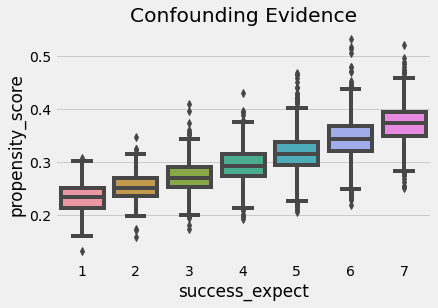

In [31]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

我们还必须检查干预和未干预人群之间是否存在重叠。 为此，我们可以看到倾向得分在未干预者和被干预者上的经验分布。 查看下图，我们可以看到没有人的倾向得分为零，即使在倾向得分较低的区域，我们也可以找到接受干预和未接受干预的个体。 这就是我们所说的经过良好平衡的干预和未干预人群。

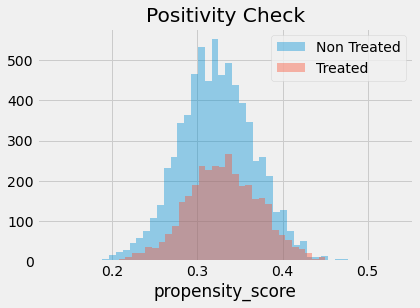

In [32]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

最后，我们可以使用倾向得分加权估计器来估计平均干预效果（ATE）。

In [33]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * data_ps["achievement_score"]))

Y1: 0.2595774244866067
Y0: -0.12892090981713242
ATE 0.38849833430373715


倾向得分加权表示，就成就而言，我们应该期望接受干预的个体比未经干预的同伴高 0.38 个标准差。 我们还可以看到，如果没有人得到干预，我们应该期望成绩的总体水平比现在低 0.12 个标准差。 同样的道理，如果我们为每个人提供研讨会，我们应该期望一般成就水平高出 0.25 个标准差。 将此与我们通过简单比较干预和未干预得到的 0.47 ATE 估计值进行对比。 这证明我们的偏差确实是正向的，并且控制 X 让我们对成长心态的影响有了更适度的估计。

## 标准误差

![img](./data/img/ps/bootstrap.png)

为了计算 IPTW 估计量的标准误差，我们可以使用加权平均方差的公式。

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

但是，只有当我们有真实的倾向得分时，我们才能使用它。 如果我们使用它的估计版本，\\(\hat{P}(x)\\)，我们需要考虑这个估计过程中的错误。 最简单的方法是引导整个过程。 这是通过从原始数据中进行自助法采样（bootstrapping）并像我们上面所做的那样计算 ATE 来实现的。 然后我们重复多次以获得 ATE 估计的分布。

In [34]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

ATE 是自助法采样样本的平均值。 为了获得置信区间，我们可以自助法采样分布的分位数。 对于 95% C.I.，我们使用 2.5 和 97.5 百分位数。

In [35]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877452824895804
95% C.I.: (0.35448188811098386, 0.41992764030841984)


我们还可以直观地了解引导样本的外观以及置信区间。

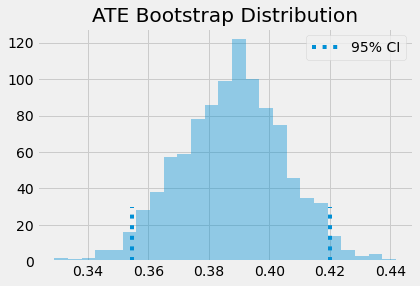

In [36]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## 倾向得分的常见问题

作为一名数据科学家，我知道使用机器学习工具包的所有功能来使倾向得分估计尽可能精确是很诱人的。你很快就会被 AUC 优化、交叉验证和贝叶斯超参数调优这些很炫的技术所吸引。我现在并不是说你不应该那样做。事实上，所有关于倾向得分和机器学习的理论都是最近才出现的，所以还有很多我们还不知道的。但首先对一些基础的东西加以理解是值得的。

首先，倾向得分的预测质量并不能转化为它的平衡特性。对于来自机器学习领域的人来说，要学好因果推理，最具挑战性的方面之一就是放弃将所有事情都视为预测问题。事实上，最大化倾向得分的预测能力甚至会损害因果推理的目标。 **倾向评分不需要很好地预测干预。它只需要包含所有混淆变量**。如果我们包括在预测干预方面非常好的变量，但对结果没有影响，这实际上会增加倾向评分估计量的方差。当我们包含与干预相关但与结果无关的变量时，这类似于线性回归面临的问题。

![img](./data/img/ps/ml-trap.png)

要了解这一点，请考虑以下示例（改编自 Hernán's 的书 [Causal Inference: What If](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)）。 假设有 2 所学校，其中一所将成长心态研讨会应用于 99% 的学生，另一所则应用于 1%。 假设学校对干预效果没有影响（即只通过干预分配进行影响），则无需对其进行控制。 如果将学校变量添加到倾向得分模型中，它将具有非常高的预测能力。 然而，有一种可能，我们最终得到一个样本，其中学校 A 的每个人都接受了干预，导致该学校的倾向得分为 1，这将导致无限方差。 这是一个极端的例子，但让我们通过模拟数据来看看具体是怎么实现的。

In [37]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


在模拟了这些数据后，我们运行两次自助法采样（bootstrapping），并对采样样本使用倾向得分算法。 第一次，倾向评分模型中包括了学校作为一个特征。 第二次，模型中不包括学校。

In [38]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

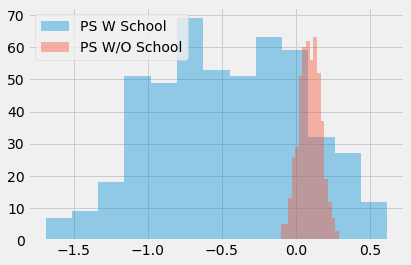

In [39]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

如你所见，添加学校这个特征的倾向得分估计器具有巨大的方差，而没有这个特征的倾向得分估计器表现得更好。 此外，由于学校不是混淆因子，因此没有它的模型也没有偏差。 正如我所说，简单地预测是否进行了干预并不是重点。 我们在进行预测的时候，实际上需要以控制混淆因子为目的来构建模型，而不是以对干预变量本身进行预测为目的。

这导致了倾向评分方法中经常遇到的另一个问题。 比如在我们的心态案例中，数据显然是非常平衡的。 但实际情况并非总是如此。 在某些情况下，接受干预的人比未经干预的人有更高的被干预概率，从而导致倾向得分分布没有太多重叠。（从而违背了positivity这个假设：译者著）

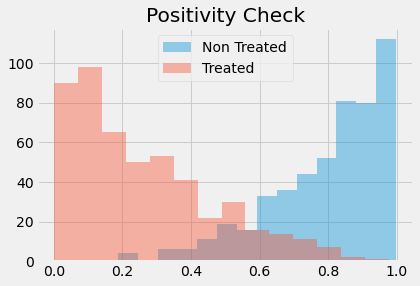

In [40]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

如果发生这种情况，则意味着正值性（positivity）不是很强。如果接受干预的人的倾向得分为 0.9，而未经干预的人的最大倾向得分为 0.7，那么我们将没有任何未经干预的人与倾向得分为 0.9 的个体进行比较。这种缺乏平衡会产生一些偏差，因为我们必须将干预结果外推到未知区域。不仅如此，倾向得分非常高或非常低的实体具有非常高的权重，这会增加方差。作为一般经验法则，如果任何权重高于 20（倾向得分为 0.95 的未干预样本或倾向得分为 0.05 的被干预样本都会发生这种情况），您就会遇到麻烦。

另一种方法是将权重限制为最大 20。这将减少方差，但实际上会产生更多偏差。老实说，虽然这是减少差异的常见做法，但我并不喜欢它。你永远不会知道你用剪裁（clipping）引起的偏差是否太大。此外，如果分布不重叠，那么您的数据可能还不足以得出因果结论。为了进一步了解这一点，我们可以研究一种结合倾向得分和匹配的技术

## 倾向得分匹配

正如我之前所说，当你有倾向得分时，你不需要控制 X。 控制它就足够了。 因此，您可以将倾向得分视为对特征空间执行一种降维。 它将 X 中的所有特征浓缩到一个单一的处理分配维度中。 因此，我们可以将倾向得分视为其他模型的输入特征。 以回归模型为例。

In [41]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0770,0.065,-47.064,0.000,-3.205,-2.949
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0553,0.200,45.317,0.000,8.664,9.447


如果我们控制倾向得分，我们现在估计 ATE 为 0.39，低于我们之前使用回归模型而不控制倾向得分得到的 0.47。 我们还可以在倾向得分上使用匹配。 这一次，我们可以找到仅具有相同倾向得分的匹配，而不是试图找到所有 X 特征中相似的匹配。

这是对匹配估计器的巨大改进，因为它处理了维度灾难。 此外，如果一个特征对干预的分配不重要，倾向评分模型将学习这一点，并在拟合干预机制时对其给予较低的重要性。 另一方面，特征匹配仍然会尝试找到个人在这个不重要特征上相似的匹配。

In [42]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.390      0.025     15.600      0.000      0.341      0.439
           ATC      0.380      0.027     13.876      0.000      0.326      0.434
           ATT      0.410      0.027     15.349      0.000      0.357      0.462



正如我们所看到的，我们也得到了 0.38 的 ATE，这更符合我们之前通过倾向得分加权看到的结果。 倾向得分的匹配也让我们对为什么在干预和未干预之间的倾向得分有小的重叠是危险的有一些直觉。 如果发生这种情况，倾向得分差异的匹配将很大，这将导致偏差，正如我们在匹配章节中看到的那样。

最后要注意的是，上述标准误差是错误的，因为它们没有考虑倾向得分估计的不确定性。 不幸的是，[自助法（bootstrap）不适用于匹配](https://economics.mit.edu/files/11862)。 此外，上述理论太新了，以至于没有具有正确标准误差的倾向评分方法的 Python 实现。 出于这个原因，我们在 Python 中看不到很多倾向得分匹配。

## 关键思想

在这里，我们了解到接受干预的概率称为倾向得分，我们可以将其用作平衡得分。这意味着，如果我们有倾向得分，我们就不需要直接控制混杂因素。为了识别因果效应，控制倾向得分就足够了。我们看到了倾向得分如何作为混杂空间的降维。

这些属性使我们能够推导出因果推理的加权估计量。不仅如此，我们还看到了如何将倾向得分与其他方法一起使用来控制混杂偏差。

然后，我们研究了倾向得分和一般因果推理可能出现的一些常见问题。第一个是当我们被分配干预机制的任务所迷惑时。我们看到，以一种非常违反直觉（因此很容易出错）的方式，提高接受干预可能的预测性反而**不会**转化为更好的因果估计，因为它会增加方差。

最后，我们研究了一些外推问题，如果我们无法在干预和未干预的倾向得分分布之间有良好的重叠，我们可能会遇到这些问题。